In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Activation, Dense,LSTM,Dropout
from sklearn.metrics import mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
import requests
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch Tweets and Sentiment data - Join from Tweet and Sentiment tables
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("")
    print("Data transfer Done")
except BaseException as err:
    print(err)

Data transfer Done


In [5]:
df_dbFinanceData

,financeType,date,open,high,low,close,adjustedClose,volume,id
0,tesla,2010-06-29,3.800000,5.000000,3.508000,4.778000,4.778000,93831500,1
1,tesla,2010-06-30,5.158000,6.084000,4.660000,4.766000,4.766000,85935500,2
2,tesla,2010-07-01,5.000000,5.184000,4.054000,4.392000,4.392000,41094000,3
3,tesla,2010-07-02,4.600000,4.620000,3.742000,3.840000,3.840000,25699000,4
4,tesla,2010-07-06,4.000000,4.000000,3.166000,3.222000,3.222000,34334500,5
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [6]:
doge_price = df_dbFinanceData[df_dbFinanceData["financeType"] == "doge"]

In [7]:
doge_price

,financeType,date,open,high,low,close,adjustedClose,volume,id
5213,doge,2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214
5214,doge,2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215
5215,doge,2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216
5216,doge,2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217
5217,doge,2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218
...,...,...,...,...,...,...,...,...,...
6916,doge,2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
6917,doge,2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
6918,doge,2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919
6919,doge,2022-07-12,0.061851,0.062861,0.060087,0.060087,0.060087,298462083,6920


In [8]:
end_date = doge_price['date'].iloc[-1]
end_date

'2022-07-13'

In [9]:
doge_price['date'] = pd.to_datetime(doge_price['date'], format='%Y-%m-%d')

SqlConn.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
doge_price.dtypes

financeType              object
date             datetime64[ns]
open                    float64
high                    float64
low                     float64
close                   float64
adjustedClose           float64
volume                    int64
id                        int64
dtype: object

In [11]:
doge_price.set_index("date",inplace = True)

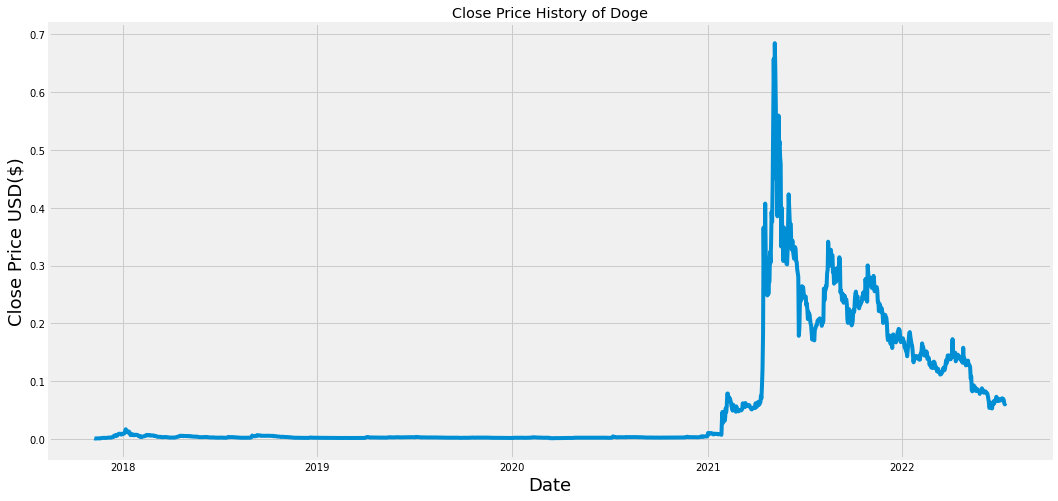

In [12]:
plt.figure(figsize=(16,8))
plt.title('Close Price History of Doge')
plt.plot(doge_price['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD($)',fontsize=18)
plt.show()

In [13]:
data = doge_price.drop(['financeType','open', 'high', 'low', 'adjustedClose', 'volume','id'], axis = 1)
price_column = 'close'
data.head()

,close
date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211


In [14]:
# This function splits the data in 70,30 ratio.
def train_test_split(df, test_size=0.3):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [15]:
train, test = train_test_split(data, test_size=0.2)

In [16]:
train.shape, test.shape

((1367, 1), (341, 1))

In [17]:
train

,close
date,
2017-11-09,0.001415
2017-11-10,0.001163
2017-11-11,0.001201
2017-11-12,0.001038
2017-11-13,0.001211
...,...
2021-08-02,0.203600
2021-08-03,0.195967
2021-08-04,0.201490


In [18]:
test

,close
date,
2021-08-07,0.260341
2021-08-08,0.240045
2021-08-09,0.256897
2021-08-10,0.257325
2021-08-11,0.265263
...,...
2022-07-09,0.069512
2022-07-10,0.067263
2022-07-11,0.061847


In [19]:
# Perform MinMax scaling
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(data).reshape(-1,1))
df1

array([[0.00055138],
       [0.00018282],
       [0.0002384 ],
       ...,
       [0.08893598],
       [0.0863619 ],
       [0.08909101]])

In [20]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.8)
# test_size=len(df1)-training_size

test_size = 0.2
split_row = len(df1) - int(test_size * len(df1))
# train_data = df.iloc[:split_row]
# test_data = df.iloc[split_row:]
    
train_scaled,test_scaled=df1[0:split_row,:],df1[split_row:,]
training_size,split_row

(1366, 1367)

In [21]:
train_scaled.shape,test_scaled.shape

((1367, 1), (341, 1))

In [22]:
train_scaled

array([[5.51379986e-04],
       [1.82818298e-04],
       [2.38395060e-04],
       ...,
       [2.93170347e-01],
       [2.92415673e-01],
       [2.97847570e-01]])

In [23]:
test_scaled

array([[0.37924266],
       [0.34955882],
       [0.37420565],
       [0.37483162],
       [0.38644132],
       [0.38447858],
       [0.41795188],
       [0.42717323],
       [0.49785518],
       [0.46754244],
       [0.43642969],
       [0.44271425],
       [0.46231969],
       [0.47745265],
       [0.46181218],
       [0.45912987],
       [0.46344585],
       [0.42077606],
       [0.42587596],
       [0.39177376],
       [0.4291038 ],
       [0.41622754],
       [0.40964023],
       [0.39647731],
       [0.4057323 ],
       [0.42905699],
       [0.43132979],
       [0.43179488],
       [0.43635071],
       [0.4584922 ],
       [0.45006501],
       [0.36959425],
       [0.37452156],
       [0.36791524],
       [0.34946668],
       [0.35158737],
       [0.36502086],
       [0.34350534],
       [0.35052995],
       [0.36075023],
       [0.35322981],
       [0.34939063],
       [0.3515201 ],
       [0.33946287],
       [0.30133282],
       [0.29249319],
       [0.32734713],
       [0.327

In [24]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [25]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 30
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, ytest = create_dataset(test_scaled, time_step)

In [26]:
print(X_train.shape), print(y_train.shape)

(1336, 30)
(1336,)


(None, None)

In [27]:
print(X_test.shape), print(ytest.shape)

(310, 30)
(310,)


(None, None)

In [28]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
print(X_train.shape), print(y_train.shape)

(1336, 30, 1)
(1336,)


(None, None)

In [30]:
print(X_test.shape), print(ytest.shape)

(310, 30, 1)
(310,)


(None, None)

In [31]:
X_test

array([[[0.37924266],
        [0.34955882],
        [0.37420565],
        ...,
        [0.43179488],
        [0.43635071],
        [0.4584922 ]],

       [[0.34955882],
        [0.37420565],
        [0.37483162],
        ...,
        [0.43635071],
        [0.4584922 ],
        [0.45006501]],

       [[0.37420565],
        [0.37483162],
        [0.38644132],
        ...,
        [0.4584922 ],
        [0.45006501],
        [0.36959425]],

       ...,

       [[0.10883685],
        [0.10070656],
        [0.09257626],
        ...,
        [0.10176836],
        [0.09977345],
        [0.1001464 ]],

       [[0.10070656],
        [0.09257626],
        [0.07734384],
        ...,
        [0.09977345],
        [0.1001464 ],
        [0.09685713]],

       [[0.09257626],
        [0.07734384],
        [0.07978776],
        ...,
        [0.1001464 ],
        [0.09685713],
        [0.08893598]]])

In [32]:
ytest

array([0.45006501, 0.36959425, 0.37452156, 0.36791524, 0.34946668,
       0.35158737, 0.36502086, 0.34350534, 0.35052995, 0.36075023,
       0.35322981, 0.34939063, 0.3515201 , 0.33946287, 0.30133282,
       0.29249319, 0.32734713, 0.3273091 , 0.30481368, 0.30362755,
       0.29824831, 0.29137434, 0.28631685, 0.28934725, 0.2971982 ,
       0.32464435, 0.31897405, 0.32279861, 0.3507391 , 0.36706697,
       0.37162719, 0.35376803, 0.35512527, 0.35913996, 0.33458235,
       0.33706575, 0.3293713 , 0.33862921, 0.33819191, 0.34039889,
       0.34553243, 0.34641874, 0.36014181, 0.35795823, 0.37010467,
       0.35298996, 0.35566642, 0.36665306, 0.40367743, 0.38562814,
       0.37250179, 0.34611453, 0.43789955, 0.41948024, 0.39094889,
       0.40835172, 0.39589668, 0.39793401, 0.39250211, 0.38354109,
       0.38088657, 0.38151985, 0.38797992, 0.41144501, 0.39852634,
       0.37246815, 0.38045073, 0.37788688, 0.38123904, 0.38300287,
       0.37366744, 0.34546954, 0.34581763, 0.32226478, 0.33941

In [33]:
np.random.seed(42)
tf.random.set_seed(42)
window_len = 30
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'
activ_func = "relu"

In [34]:
# model = Sequential()
# model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(dropout))
# model.add(Dense(units=1))
# model.add(Activation(activ_func))
# model.compile(loss=loss, optimizer=optimizer)
# model.summary()

In [35]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
42/42 [==============================] - 9s 36ms/step - loss: 0.0047
Epoch 2/100
42/42 [==============================] - 1s 35ms/step - loss: 0.0019
Epoch 3/100
42/42 [==============================] - 1s 35ms/step - loss: 0.0019
Epoch 4/100
42/42 [==============================] - 1s 34ms/step - loss: 0.0016
Epoch 5/100
42/42 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 6/100
42/42 [==============================] - 1s 35ms/step - loss: 0.0014
Epoch 7/100
42/42 [==============================] - 1s 35ms/step - loss: 0.0021
Epoch 8/100
42/42 [==============================] - 1s 34ms/step - loss: 0.0014
Epoch 9/100
42/42 [==============================] - 1s 34ms/step - loss: 0.0013
Epoch 10/100
42/42 [==============================] - 2s 43ms/step - loss: 0.0012
Epoch 11/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0011
Epoch 12/100
42/42 [==============================] - 2s 40ms/step - loss: 0.0012
Epoch 13/100
42/42 [=====

Epoch 97/100
42/42 [==============================] - 2s 41ms/step - loss: 3.7667e-04
Epoch 98/100
42/42 [==============================] - 2s 40ms/step - loss: 4.0034e-04
Epoch 99/100
42/42 [==============================] - 2s 39ms/step - loss: 4.3321e-04
Epoch 100/100
42/42 [==============================] - 2s 41ms/step - loss: 3.3079e-04


In [37]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

10/10 [==============================] - 0s 14ms/step


In [38]:
test_predict

array([[0.42563495],
       [0.4266775 ],
       [0.37729084],
       [0.33833635],
       [0.32313964],
       [0.31877548],
       [0.32384562],
       [0.33750883],
       [0.3350613 ],
       [0.32986096],
       [0.33133477],
       [0.33103845],
       [0.32871953],
       [0.32851365],
       [0.3230735 ],
       [0.29797533],
       [0.2735891 ],
       [0.28103787],
       [0.29900843],
       [0.29987565],
       [0.29128212],
       [0.279274  ],
       [0.26823413],
       [0.2612589 ],
       [0.2620825 ],
       [0.27072954],
       [0.29335472],
       [0.30698657],
       [0.3105216 ],
       [0.32188064],
       [0.33860397],
       [0.3501516 ],
       [0.34201   ],
       [0.32999122],
       [0.32524312],
       [0.31380817],
       [0.3082261 ],
       [0.30488285],
       [0.30994326],
       [0.31615534],
       [0.3209802 ],
       [0.3255237 ],
       [0.32810813],
       [0.3362367 ],
       [0.34136072],
       [0.34926033],
       [0.3443274 ],
       [0.337

In [39]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

0.019547068396064318

In [40]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

0.01989260233161144

In [41]:
# Calculate the Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae=mean_absolute_error(ytest,test_predict)
mae

0.015345383097120793

In [42]:
# Calculate Mean Absolute error using Sklearn library
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(ytest,test_predict)

0.06709295657058105

In [43]:
# Manual calculation of Mean Absolute Percentage error.
total = 0
for i,j in zip(ytest, test_predict):
    value = abs(i-j)/abs(i)
    total+= value
#     print(total)
error = float(total*100/(len(ytest))) # Calculate MAPE
mape = round(error,2) # round to 3 significant figures
print(mape)

6.71


In [44]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [45]:
test_predict.shape

(310, 1)

In [46]:
targets = test[price_column][window_len+1:]
targets

date
2021-09-07    0.253744
2021-09-08    0.257113
2021-09-09    0.252596
2021-09-10    0.239982
2021-09-11    0.241432
                ...   
2022-07-09    0.069512
2022-07-10    0.067263
2022-07-11    0.061847
2022-07-12    0.060087
2022-07-13    0.061953
Name: close, Length: 310, dtype: float64

In [47]:
preds = pd.Series(index=targets.index, data=test_predict.squeeze())
preds

date
2021-09-07    0.292061
2021-09-08    0.292774
2021-09-09    0.259006
2021-09-10    0.232372
2021-09-11    0.221981
                ...   
2022-07-09    0.065115
2022-07-10    0.065760
2022-07-11    0.065988
2022-07-12    0.064986
2022-07-13    0.061440
Length: 310, dtype: float32

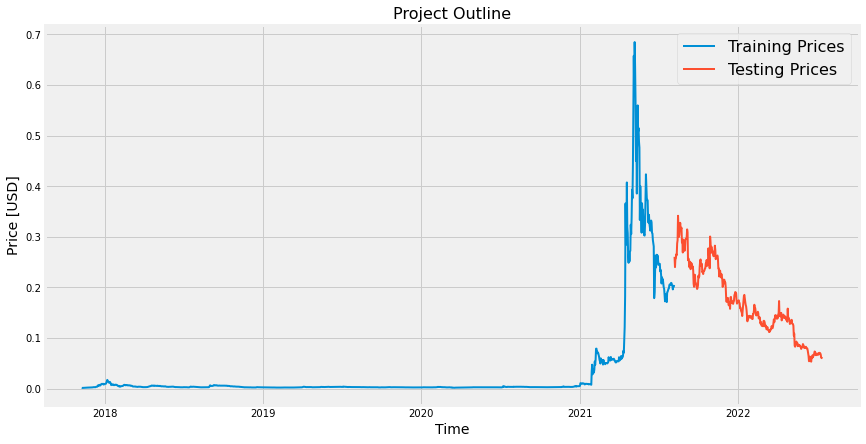

In [48]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USD]', fontsize=14)
    ax.set_xlabel('Time', fontsize = 14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train["close"], test["close"], 'Training Prices', 'Testing Prices', title='Project Outline')

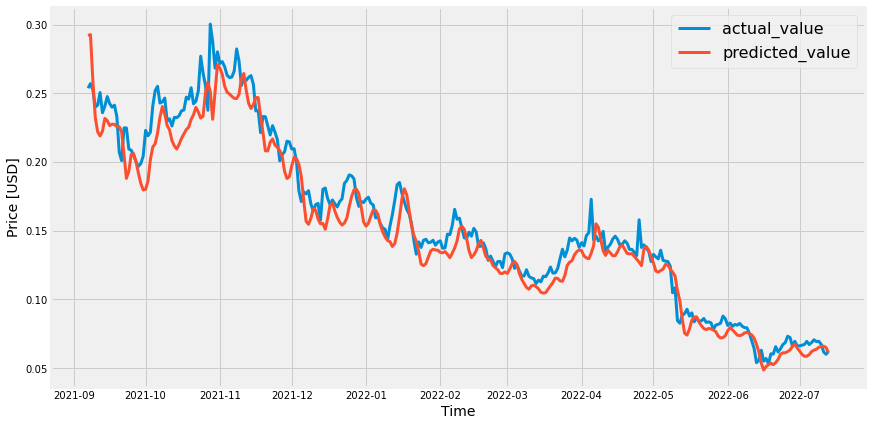

In [49]:
line_plot(targets, preds, 'actual_value', 'predicted_value', lw=3)

### Future Prediction for 30 days

In [50]:
len(test)

341

In [51]:
length = len(test_scaled)
length

341

In [52]:
#Getting the last 100 days records
fut_inp = test_scaled[length-30:]
fut_inp.shape

(30, 1)

In [53]:
fut_inp = fut_inp.reshape(1,-1)

In [54]:
fut_inp.shape

(1, 30)

In [55]:
fut_inp

array([[0.07978776, 0.0906223 , 0.07896434, 0.08183971, 0.07601439,
        0.08681383, 0.08649353, 0.09438251, 0.08873708, 0.09213165,
        0.09665384, 0.09867069, 0.10550663, 0.10413476, 0.09494705,
        0.10008205, 0.09513572, 0.09526588, 0.0960308 , 0.09673428,
        0.1000879 , 0.09669918, 0.0987877 , 0.10176836, 0.09977345,
        0.1001464 , 0.09685713, 0.08893598, 0.0863619 , 0.08909101]])

In [56]:
tmp_inp = list(fut_inp)

In [57]:
tmp_inp

[array([0.07978776, 0.0906223 , 0.07896434, 0.08183971, 0.07601439,
        0.08681383, 0.08649353, 0.09438251, 0.08873708, 0.09213165,
        0.09665384, 0.09867069, 0.10550663, 0.10413476, 0.09494705,
        0.10008205, 0.09513572, 0.09526588, 0.0960308 , 0.09673428,
        0.1000879 , 0.09669918, 0.0987877 , 0.10176836, 0.09977345,
        0.1001464 , 0.09685713, 0.08893598, 0.0863619 , 0.08909101])]

In [58]:
#Creating list of the last 100 data
tmp_inp = tmp_inp[0].tolist()

In [59]:
tmp_inp

[0.07978775526918898,
 0.09062229885965259,
 0.0789643416566848,
 0.08183970784173493,
 0.07601438560620354,
 0.0868138280835231,
 0.08649353042608364,
 0.09438250560520901,
 0.08873707657454089,
 0.09213164672484678,
 0.09665384013490529,
 0.09867069159430718,
 0.10550663337911105,
 0.10413476487373106,
 0.09494704850827583,
 0.10008204885197423,
 0.0951357169914251,
 0.09526588361933429,
 0.09603079537659838,
 0.0967342801858604,
 0.10008789903749825,
 0.09669917907271636,
 0.09878769530478737,
 0.10176836482926965,
 0.09977345156558277,
 0.10014640089273832,
 0.09685713408186458,
 0.08893598288235716,
 0.08636190125179345,
 0.08909101279874339]

In [60]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=30
i=0
while(i<30):
    
    if(len(tmp_inp)>30):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.08055642992258072], [0.07738295197486877], [0.07365524768829346], [0.06967257708311081], [0.06566496938467026], [0.061689574271440506], [0.057881612330675125], [0.054247740656137466], [0.05085216462612152], [0.0476473867893219], [0.04465412348508835], [0.04183809086680412], [0.03914369270205498], [0.036538153886795044], [0.03393404185771942], [0.031251952052116394], [0.02850533276796341], [0.025617681443691254], [0.022598519921302795], [0.019451357424259186], [0.016194723546504974], [0.012871998362243176], [0.00949675589799881], [0.006140563637018204], [0.0028531402349472046], [-0.00034052086994051933], [-0.0033887315075844526], [-0.006276756525039673], [-0.009002353996038437], [-0.011530322022736073]]


In [61]:
end_date

'2022-07-13'

In [62]:
temp = pd.to_datetime(end_date, format='%Y-%m-%d')
temp
end_date_new = temp.strftime('%m/%d/%Y')
end_date_new

'07/13/2022'

In [63]:
preds = scaler.inverse_transform(lst_output)
preds

array([[ 0.05611757],
       [ 0.05394774],
       [ 0.05139897],
       [ 0.04867586],
       [ 0.0459357 ],
       [ 0.04321757],
       [ 0.04061392],
       [ 0.0381293 ],
       [ 0.03580761],
       [ 0.03361638],
       [ 0.03156977],
       [ 0.02964433],
       [ 0.02780207],
       [ 0.02602056],
       [ 0.02424003],
       [ 0.02240618],
       [ 0.02052821],
       [ 0.01855381],
       [ 0.01648949],
       [ 0.01433765],
       [ 0.01211096],
       [ 0.00983909],
       [ 0.0075313 ],
       [ 0.00523654],
       [ 0.0029888 ],
       [ 0.00080517],
       [-0.00127901],
       [-0.00325366],
       [-0.00511726],
       [-0.00684573]])

In [64]:
import datetime
date_future = temp + datetime.timedelta(41)
date_future_str = date_future.strftime('%m/%d/%Y')
date_future_str

'08/23/2022'

In [65]:
c = pd.date_range(start=end_date_new, end=date_future_str, freq='B')
c

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [66]:
len(c)

30

In [67]:
fut_preds = pd.Series(index=c, data=preds.squeeze())
fut_preds

2022-07-13    0.056118
2022-07-14    0.053948
2022-07-15    0.051399
2022-07-18    0.048676
2022-07-19    0.045936
2022-07-20    0.043218
2022-07-21    0.040614
2022-07-22    0.038129
2022-07-25    0.035808
2022-07-26    0.033616
2022-07-27    0.031570
2022-07-28    0.029644
2022-07-29    0.027802
2022-08-01    0.026021
2022-08-02    0.024240
2022-08-03    0.022406
2022-08-04    0.020528
2022-08-05    0.018554
2022-08-08    0.016489
2022-08-09    0.014338
2022-08-10    0.012111
2022-08-11    0.009839
2022-08-12    0.007531
2022-08-15    0.005237
2022-08-16    0.002989
2022-08-17    0.000805
2022-08-18   -0.001279
2022-08-19   -0.003254
2022-08-22   -0.005117
2022-08-23   -0.006846
Freq: B, dtype: float64

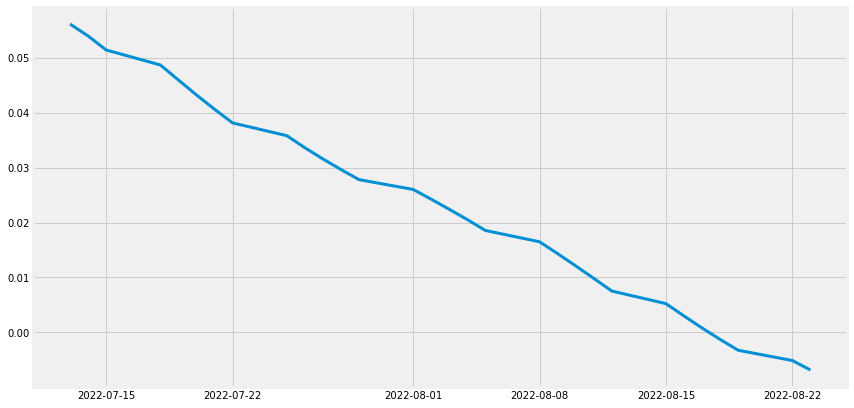

In [68]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(fut_preds, label="predicted value_30", linewidth=3)

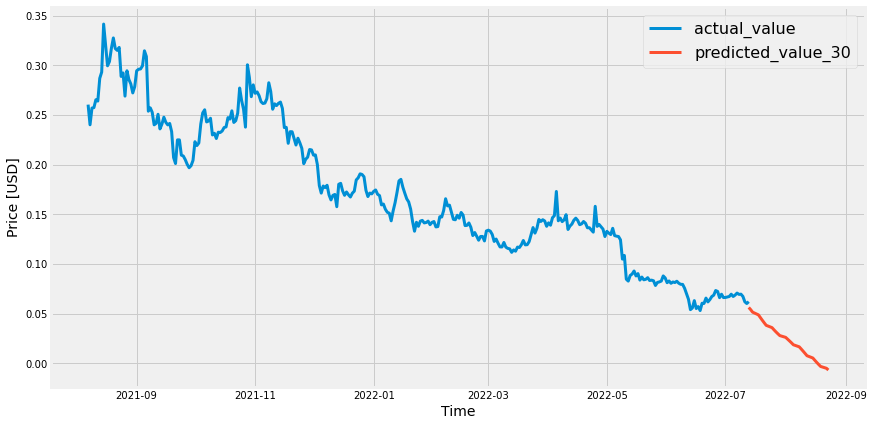

In [69]:
line_plot(test["close"], fut_preds, 'actual_value', 'predicted_value_30', lw=3)